In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D


import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [6]:
model_n = 0
task_list = ['fdgo','fdanti','delaygo','delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = '4_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','LDlabs','input_art')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [7]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']
    
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [30]:
npr.randn()

0.42184702216140424

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


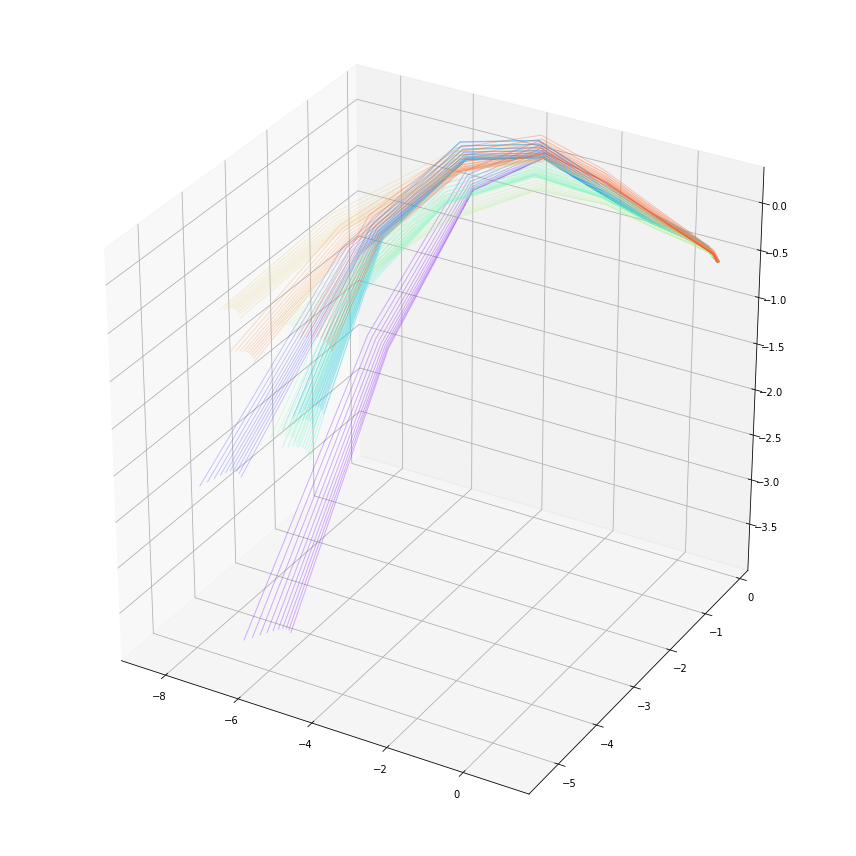

In [53]:
epoch = 'stim1'
t_num = 0
n_steps = 500
nD = 3

fig = plt.figure(figsize=(12,12),tight_layout=True,facecolor='white')
ax = plt.subplot(111,projection = '3d')
model = Model(m)

w_in = params[0]
b_in = params[1]
w_out = params[2]
b_out = params[3]

ins = np.shape(w_in)[0]
recs = np.shape(w_in)[1]
cmap = plt.get_cmap('rainbow')
n_people = 10

with tf.Session() as sess:
    model.restore()
    model._sigma=0
    hparams = model.hp
    alpha = hparams['dt']/hparams['tau']
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    
    for prm in range(n_people):
        params[0] = w_in
        for n in range(100):
            params[0][npr.randint(ins),npr.randint(recs)] = npr.randn()

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,epoch) # grab epoch time indexing
        x_t = trial.x[:,t_num,:]

        full_data1 = h_tf[15,:,:]
        pca = PCA(n_components = nD)
        pca_data1 = pca.fit_transform(full_data1)
        D_use = pca.components_

        for jit in range(10):
            h0 = h_tf[T_inds[0],jit*2,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use.T)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = cmap(prm/n_people),linewidth = 1, alpha = .3)


In [54]:
np.shape(x_t)

(100, 25)